# Neural Network Autoencoder in Keras

This is a similar example to the other 2 which were written in Numpy and Theano.  Again, I have tied the weights in this network.  In order to do this in Keras, I had to create a new layer type and overide a few of the functions so that the weights used at this layer are tied to another layer in the network.  Other than that, Keras is obviously much easier because all of the code for optimizers and layers is written and you can just focus on designing the network you would like.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K


# Create TiedDense layer type

I inherit from the Dense layer type in Keras.  You pretty much just call the Dense constructor to setup everything as you normally would with a Dense layer, but now you have parameters to tell you what layer to tie the weights to and whether those weights should be transposed (like in an Autoencoder).  You could also use this to tie weights in another network type, but I didn't test it out.

In [12]:
class TiedDense(Dense):
    '''Dense layer with weights tied to another layer (either directly or as transform of the weights)

    # Arguments - similar to Dense layer with 2 additional possible arguments:
        tied_layer = layer to tie the weights to
        tied_as_transform = use the transform of the weights from the tied_layer (like an autoencoder)
    '''
    def __init__(self, output_dim, activation=None, b_regularizer=None, activity_regularizer=None,
                 b_constraint=None, bias=True, input_dim=None, tied_layer=None,
                 tied_as_transform=False, **kwargs):
        
        # call the original Dense constructor
        Dense.__init__(self, output_dim, init='glorot_uniform',
                 activation=activation, weights=None,
                 W_regularizer=None, b_regularizer=b_regularizer, activity_regularizer=activity_regularizer,
                 W_constraint=None, b_constraint=b_constraint,
                 bias=bias, input_dim=input_dim, **kwargs)
        # set the 2 new values for TiedDense class
        self.tied_layer = tied_layer
        self.tied_as_transform = tied_as_transform

    def build(self, input_shape):
        Dense.build(self, input_shape)
        # set the weights to be the transpose of the tied Layer
        # and tell keras to train only the biases
        if self.tied_as_transform is True:
            self.W = self.tied_layer.W.T
        else:
            self.W = self.tied_layer.W
        # make only the bias trainable
        if self.bias is True:
            self.trainable_weights=[self.b]
        else:
            self.trainable_weights=[]

# Test function

This is the function that loads the example data, generates the Keras model, trains the layer, and then shows a plot of the incoming data/encoded data/decoded data.

In [15]:
def TestAutoEncoder():
    # Load simple example data, randomize the order, and then scale every
    # feature to between 0 & 1.  This example is 2 donuts at different radii
    # (and noise around them) with 2 columns that are correlated.  An
    # autoencoder (among other techniques) should be able to reduce this down
    # to 2 significant features instead of the original 4.
    data = np.load('../../data/donut_corr2.npy')
    data = shuffle(data, random_state=147)  # random_state set for testing
    Xtrain = data[:,:-1].astype(np.float32)
    Ytrain = data[:,-1].astype(np.int64)
    Xtrain = MinMaxScaler((0,1)).fit_transform(Xtrain)
    # build simple autoencoder with Keras layers
    # encoded in 2 hidden units for the example
    model = Sequential()
    model.add(Dense(output_dim=2, input_dim=Xtrain.shape[1]))
    model.add(Activation('sigmoid'))
    model.add(TiedDense(output_dim=Xtrain.shape[1], tied_layer=model.layers[0],
                        tied_as_transform=True))
    # now train the model
    sgd = keras.optimizers.SGD(lr=0.1, momentum=0.95, decay=0.00001)
    model.compile(loss='mean_squared_error', metrics=['mean_squared_error'],
                  optimizer=sgd)
    history = model.fit(Xtrain, Xtrain, nb_epoch=3000,
                        batch_size=Xtrain.shape[0], validation_split=0.33, verbose=0)
    # calculate the predicted and also generate the output of the encoder
    predicted = model.predict(Xtrain, batch_size=Xtrain.shape[0])
    encoder_func = K.function([model.layers[0].input],
                              [model.layers[1].output])
    encoder_output = encoder_func([Xtrain])[0]
    # verify the weights are the same
    weights_0 = model.layers[0].W.eval()
    weights_2 = model.layers[2].W.eval()
    assert (weights_0 != weights_2.T).sum() == 0
    # plot the data - the input data (first 2 columns), the encoded output, the decoded output, and the MSE vs. epoch
    ax = plt.subplot(2,2,1)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title('Incoming Data')
    plt.scatter(Xtrain[:,0], Xtrain[:,1], c=Ytrain, s=100, alpha=0.5)
    ax = plt.subplot(2,2,2)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title('Encoded Data')
    plt.scatter(encoder_output[:,0], encoder_output[:,1], c=Ytrain, s=100, alpha=0.5)
    ax = plt.subplot(2,2,3)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title('Decoded Data')
    plt.scatter(predicted[:,0], predicted[:,1], c=Ytrain, s=100, alpha=0.5)
    ax = plt.subplot(2,2,4)
    ax.set_title('Cost vs. epoch')
    plt.plot(history.history['mean_squared_error'])
    plt.tight_layout()
    plt.show()

# Test the autoencoder

Looks pretty good.  Probably could be better with more epochs.

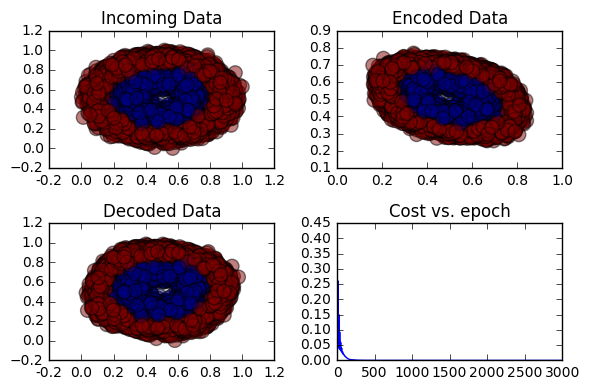

In [16]:
TestAutoEncoder()